In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Good matches encontrados: 2720


Text(0.5, 1.0, 'Matches entre las dos imágenes')

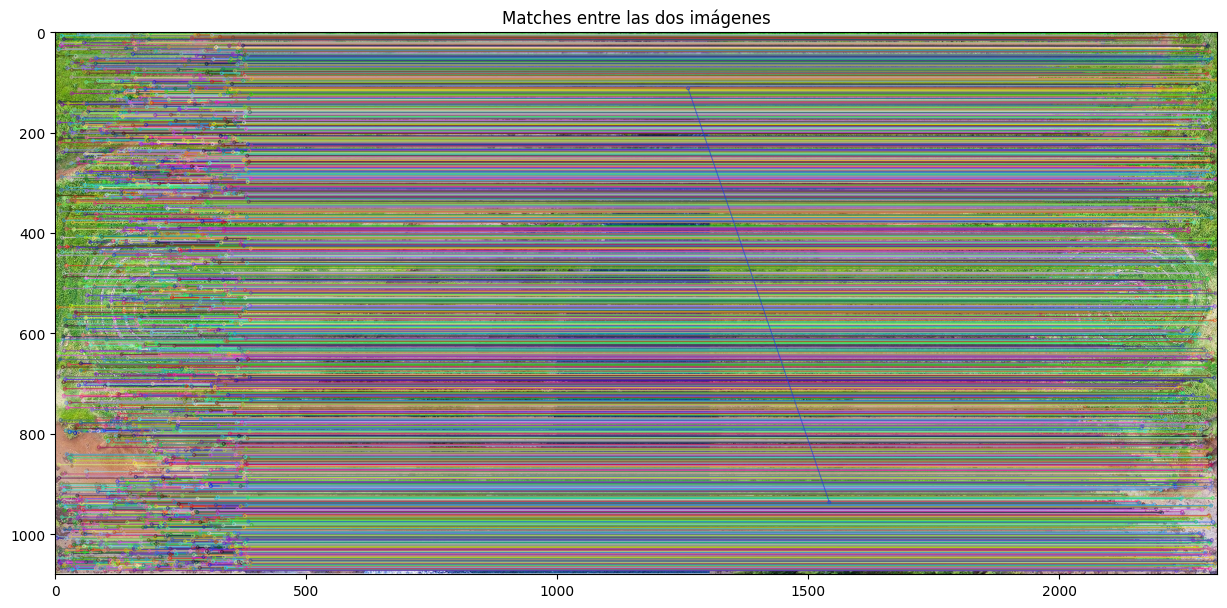

In [2]:
# cargar las imagenes
img_left = cv2.imread('1.png')
img_right = cv2.imread('2.png')

# convertir a escala de grises
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

# SIFT para detectar keypints
sift = cv2.SIFT_create()
kp_left, des_left = sift.detectAndCompute(gray_left, None) # Train (destino)
kp_right, des_right = sift.detectAndCompute(gray_right, None) # Query (origen)


# Marching FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5) 
search_params = dict(checks=50)
# print(index_params)

flann = cv2.FlannBasedMatcher(index_params, search_params)

# Derecha es query
# Izquierda es nuestro train 
matches = flann.knnMatch(des_right, des_left, k=2)
# print(matches)
# print(len(matches))

# Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

print(f"Good matches encontrados: {len(good_matches)}")

# Dibujar los matches
img_matches = cv2.drawMatches(img_right, kp_right, img_left, kp_left, good_matches, None, flags=2)
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('Matches entre las dos imágenes')

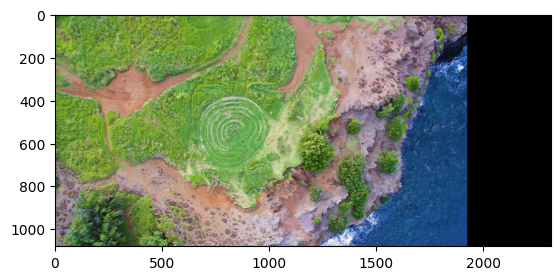

In [3]:
# Homografía 

# Extraer cordenadas de los x, y 
src_pts = np.float32([kp_right[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_left[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Ransac
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp * deformación
# Calcular nuestro canvas/lienzo

h_left, w_left = img_left.shape[:2]
h_right,w_right = img_right.shape[:2]

#Ancho de  la imagen 1 + el ancho de la imagen 2  (Ancho = i1.w + i2.w)
# alto = de la imagen de imagen más alto

canvas_w= w_left + w_right
canvas_h = max(h_left, h_right)

#Deformamos la imagen de la derecha como la base es la izquierda
# la derecha se movera hacia coordenadas positivas

panorama = cv2.warpPerspective(img_right, M, (canvas_w, canvas_h))
panorama[0:img_left.shape[0], 0:img_left.shape[1]] = img_left

dst_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
plt.imshow(dst_rgb)
plt.show()

(np.float64(-0.5), np.float64(1920.5), np.float64(1079.5), np.float64(-0.5))

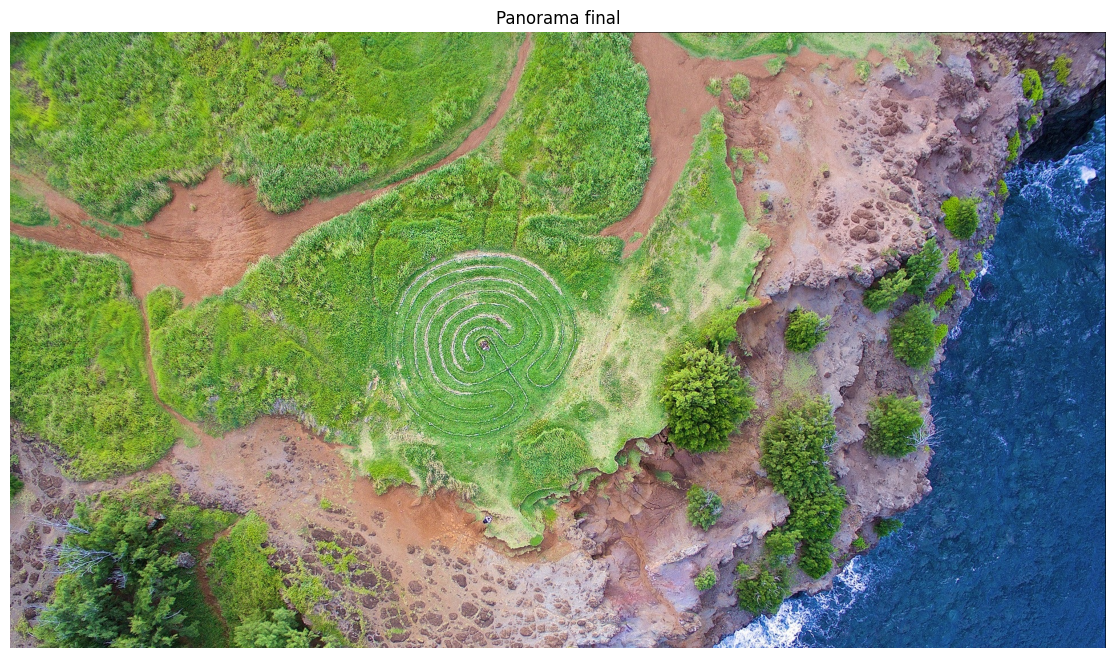

In [4]:
panorama_gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
_, mask_content = cv2.threshold(panorama_gray, 1, 255, cv2.THRESH_BINARY)

mask_inv = cv2.bitwise_not(mask_content)

left_on_canvas = np.zeros_like(panorama)
left_on_canvas[0:h_left, 0:w_left] = img_left

img_left_part = cv2.bitwise_and(left_on_canvas, left_on_canvas, mask=mask_inv)
panorama_part = cv2.bitwise_and(panorama, panorama, mask=mask_content)

result = cv2.add(img_left_part, panorama_part)

rows, cols = np.where(result[:, :, 0] != 0)
if len(cols) > 0:
    max_col = np.max(cols)
    result = result[:, :max_col + 1]

plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Panorama final')
plt.axis('off')